In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

%matplotlib notebook

In [17]:
true_params = np.array([1])
def get_dkl(p, q, n_samples=10000):
    samples = p.gen(n_samples)
    return -np.mean(q.eval(samples, log=True) - p.eval(samples, log=True))

target = dd.MoG(a=[0.5,0.5], ms=[-true_params,true_params], Ss=[[[1]],[[1]]])

def plot_surface(with_reverse=True, penaliser=0):
    xlist = np.linspace(0, 2, 20)
    ylist = np.linspace(-1.5, 1.5, 30)

    X,Y = np.meshgrid(xlist, ylist)

    dists = [ dd.MoG(a=[0.5, 0.5], ms = [-x * true_params, x * true_params], Ss=[[[y]], [[y]]]) 
              for x, y in zip(X.ravel(),np.exp(Y.ravel())) ]

    zlist = [ get_dkl(d, target) for d in dists ]
    
    zlist_penaliser = [ z - penaliser * x for z, x in zip(zlist, X.ravel()) ]
    Z = np.reshape(zlist_penaliser, X.shape)
    
    if with_reverse:
        zlistr = [ get_dkl(target, d) for d in dists ]
        Zr = np.reshape(zlistr, X.shape)

    if with_reverse:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(211, projection='3d')
        axr = fig.add_subplot(212, projection='3d')
    else:
        fig = plt.figure(figsize=(12,8))

        ax = fig.add_subplot(111, projection='3d')

    if penaliser == 0:
        fig.suptitle("KL divergence between $p$ and $q(\lambda,\sigma^2)$")
    else:
        fig.suptitle("KL divergence between $p$ and $q(\lambda,\sigma^2)$ with penaliser $r={}$".format(penaliser))
    
    if with_reverse:
        axr.set_xlabel("Mean coefficient ($\\lambda$)")
        axr.set_ylabel("Log Variance ($\log{\\sigma^2}$)")
        if penaliser == 0:
            axr.set_zlabel("DKL")
            axr.set_title("$KL(p||q(\\lambda, \\sigma^2))$")
        else:
            axr.set_zlabel("DKL + penaliser")
            axr.set_title("$KL(p||q(\\lambda, \\sigma^2)) + 2r \lambda$")

        axr.plot_surface(X, Y, Zr, cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_xlabel("Mean coefficient ($\\lambda$)")
    ax.set_ylabel("Log Variance ($\log{\\sigma^2}$)")
    if penaliser == 0:
        ax.set_zlabel("DKL")
        ax.set_title("$KL(p||q(\\lambda, \\sigma^2))$")
    else:
        ax.set_zlabel("DKL + penaliser")
        ax.set_title("$KL(p||q(\\lambda, \\sigma^2)) + 2r \lambda$")

    ax.plot_surface(X, Y, Z, cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)
    
    ax.scatter([1], [0], [-penaliser * 1], c='r')

    plt.show()
    return fig

## Trying to match a mixture of two Gaussians with an MDN

- Fix $x > 0$ (we will take $x = 1$). We assume our target distribution $p$ is an equal mixture of two Gaussians with means $\pm x$ and variances $1$
- We approximate the target within the family $q(\lambda, \sigma^2)$, where $q(\lambda, \sigma^2)$ is an equal mixture of two Gaussians with means $\pm \lambda x$ and variances $\sigma^2$. Then $p=q(1, 1)$.
- We perform gradient descent on $\lambda$ and $\sigma$ in order to minimise $KL(p || q(\lambda, \sigma^2))$ or $KL(q(\lambda, \sigma^2) || p)$

<IPython.core.display.Javascript object>


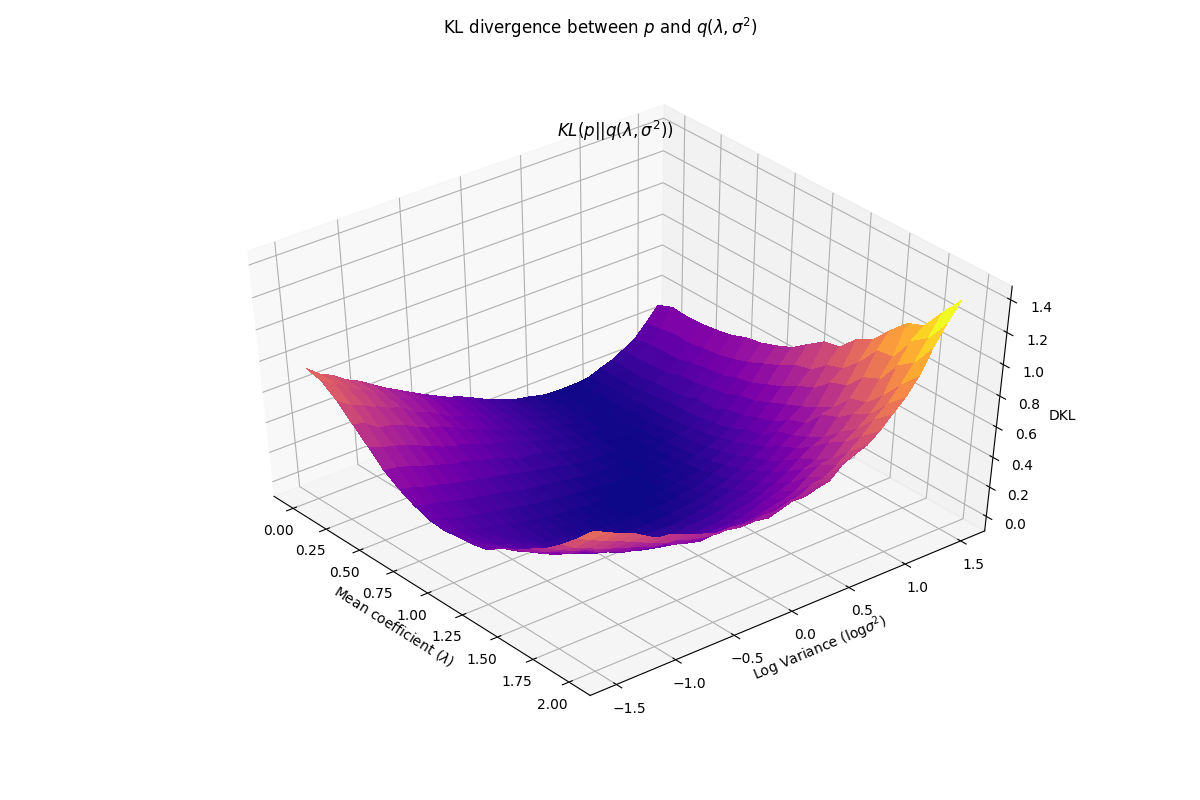

In [18]:
plot_surface(with_reverse=False, penaliser=0);

- We see that $\lambda \simeq 0$ and $\sigma^2 \geq 2$ is is connected to ground truth by a flat valley
- If we start with $\lambda \simeq 0$, then gradient descent will end up in this valley, but not necessarily in the correct place
- If the two modes of $q(\lambda, \sigma^2)$ are too close, the result will likely be unimodal (bad)
- With SGD, small sample sizes will lead to an erratic descent, worsening the problem

## Adding a penaliser

- Formula for $KL$ divergence between two Gaussians contains the squared distance between two means
- If we added a regulariser which is equal to the (linear) distance between the two modes of $q$ (in our case: $2\lambda x$), we would penalise mode coalescence
- Quadratic term in DKL will ensure that the modes stay in a bounded region (finite separation)
- Problems: a) Need to choose prefactor associated to regulariser term b) Minimum shifts away from GT
- Second problem can be solved by adding final round without penaliser

<IPython.core.display.Javascript object>


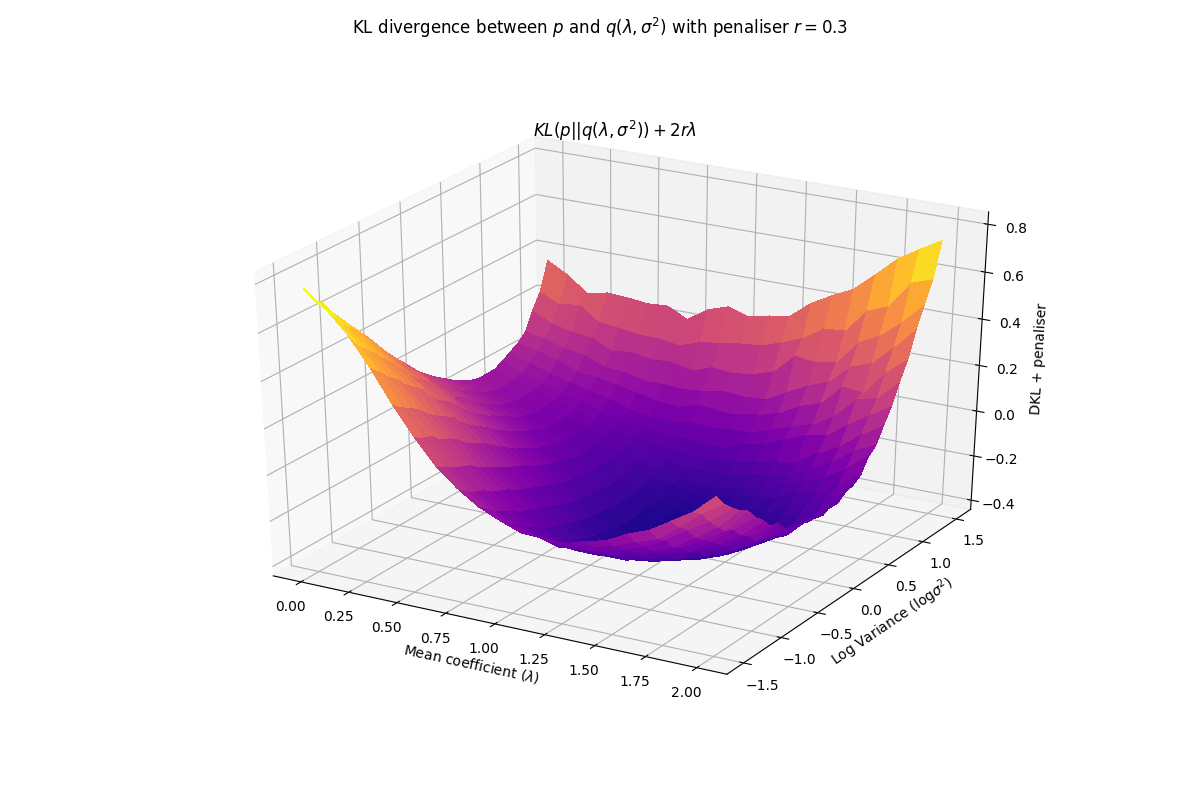

In [21]:
plot_surface(with_reverse=False, penaliser=0.3);